In [1]:
import photutils
from photutils import detect_sources, detect_threshold, aperture_photometry
from photutils import source_properties#, properties_table
from photutils import Background2D, MedianBackground
from photutils import CircularAnnulus, CircularAperture
from photutils.utils import random_cmap
from photutils.utils import calc_total_error

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import hstack
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import glob

In [2]:
extinction_coeffs = {'U': 0.50,'B': 0.25, 'V': 0.15, 'R': 0.10, 'I': 0.07}

def flux_airmass_correction(flux, airmass, filt):
    """This function corrects the measured flux to an airmass of 0"""
    return flux * np.exp(0.4 * extinction_coeffs[filt] * airmass)


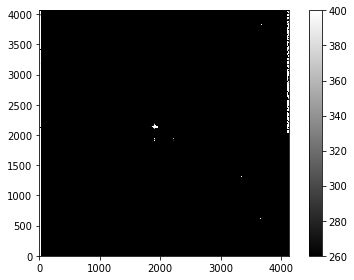

In [3]:
# Science data

img_files = glob.glob("science/calibrated/astrometry/"+'*.fits')
data = [fits.getdata(i) for i in img_files]
data = np.nan_to_num(data)  # Make any NaN's = 0
headers = [fits.getheader(i) for i in img_files]

airmass = [i['SECZ'] for i in headers]
# airmass[7] = 2.917
# airmass[8] = 3.024
# airmass[9] = 2
# airmass[10] = 1.878
    
filt = [i['MISFLTID'] for i in headers]
# filt[7] = filt[8] = filt[9] = filt[10] = "R"

order = [12, 15]
# c = 0
# for i in filt:
#     print(order[c], i, c)
#     c += 1

wcs_transform_list = [wcs.WCS(i) for i in headers]

plt.imshow(data[0], origin='lower', cmap='gray', vmin=260, vmax=400)
plt.colorbar()
plt.tight_layout()


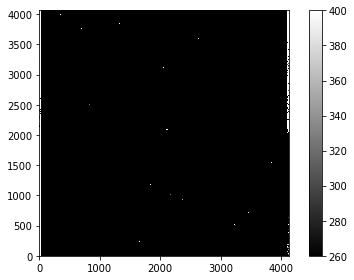

In [4]:
# standard data

std_img_files = glob.glob("science/calibrated/astrometry/standards/"+'*.fits')
std_data = [fits.getdata(i) for i in std_img_files]
std_data = np.nan_to_num(std_data)  # Make any NaN's = 0
std_headers = [fits.getheader(i) for i in std_img_files]

std_airmass = [i['SECZ'] for i in std_headers]
# std_airmass[3] = 1.726

std_filt = [i['MISFLTID'] for i in std_headers]
# std_airmass[3] = "R"

std_order = [12, 15]
# c = 0
# for i in std_filt:
#     print(order[c], i, c)
#     c += 1

std_wcs_transform_list = [wcs.WCS(i) for i in std_headers]

plt.imshow(std_data[0], origin='lower', cmap='gray', vmin=260, vmax=400)
plt.colorbar()
plt.tight_layout()

In [5]:
star_12_wcs = wcs_transform_list[0]
star_15_wcs = wcs_transform_list[1]

std_12_wcs = std_wcs_transform_list[0]
std_15_wcs = std_wcs_transform_list[1]

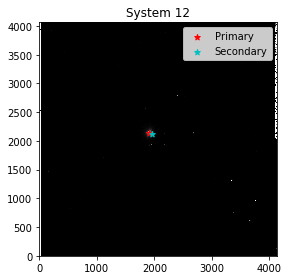

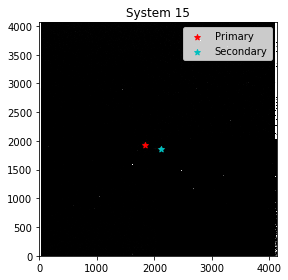

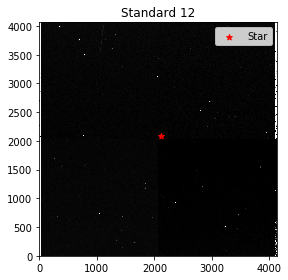

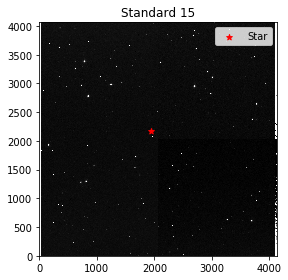

In [21]:
obj_coords_table = pd.read_csv('object_coords.txt', delimiter=',')

frame_star_12 = obj_coords_table.iloc[[0,1], [0,1,2,3,4]]
frame_star_15 = obj_coords_table.iloc[[2,3], [0,1,2,3,4]]
frame_std_12 = obj_coords_table.iloc[[4], [0,1,2,3,4]]
frame_std_15 = obj_coords_table.iloc[[5], [0,1,2,3,4]]

obj_coords_star_12 = SkyCoord(frame_star_12.ra, frame_star_12.dec, 
                      unit=(u.hour, u.deg), equinox='J2000')
obj_coords_star_15 = SkyCoord(frame_star_15.ra, frame_star_15.dec, 
                      unit=(u.hour, u.deg), equinox='J2000')
obj_coords_std_12 = SkyCoord(frame_std_12.ra, frame_std_12.dec, 
                      unit=(u.hour, u.deg), equinox='J2000')
obj_coords_std_15 = SkyCoord(frame_std_15.ra, frame_std_15.dec, 
                      unit=(u.hour, u.deg), equinox='J2000')


# Convert sky coordinates to pixels using the WCS
x_pix_12, y_pix_12 = obj_coords_star_12.to_pixel(star_12_wcs)
pix_coords_12 = list(zip(x_pix_12, y_pix_12))
x_pix_15, y_pix_15 = obj_coords_star_15.to_pixel(star_15_wcs)
pix_coords_15 = list(zip(x_pix_15, y_pix_15))

x_pix_std_12, y_pix_std_12 = obj_coords_std_12.to_pixel(std_12_wcs)
pix_coords_std_12 = list(zip(x_pix_std_12, y_pix_std_12))
x_pix_std_15, y_pix_std_15 = obj_coords_std_15.to_pixel(std_15_wcs)
pix_coords_std_15 = list(zip(x_pix_std_15, y_pix_std_15))

# plotting
plt.imshow(data[0], origin='lower', cmap='gray', vmin=10, vmax=400)
plt.scatter(x_pix_12[0], y_pix_12[0], marker='*', color='r', label='Primary')
plt.scatter(x_pix_12[1], y_pix_12[1], marker='*', color='c', label='Secondary')
plt.legend()
plt.title("System 12")
plt.tight_layout()
plt.show()

plt.imshow(data[1], origin='lower', cmap='gray', vmin=10, vmax=400)
plt.scatter(x_pix_15[0], y_pix_15[0], marker='*', color='r', label='Primary')
plt.scatter(x_pix_15[1], y_pix_15[1], marker='*', color='c', label='Secondary')
plt.legend()
plt.title("System 15")
plt.tight_layout()
plt.show()

plt.imshow(std_data[0], origin='lower', cmap='gray', vmin=10, vmax=400)
plt.scatter(x_pix_std_12[0], y_pix_std_12[0], marker='*', color='r', label='Star')
plt.legend()
plt.title("Standard 12")
plt.tight_layout()
plt.show()

plt.imshow(std_data[1], origin='lower', cmap='gray', vmin=10, vmax=400)
plt.scatter(x_pix_std_15[0], y_pix_std_15[0], marker='*', color='r', label='Star')
plt.legend()
plt.title("Standard 15")
plt.tight_layout()
plt.show()

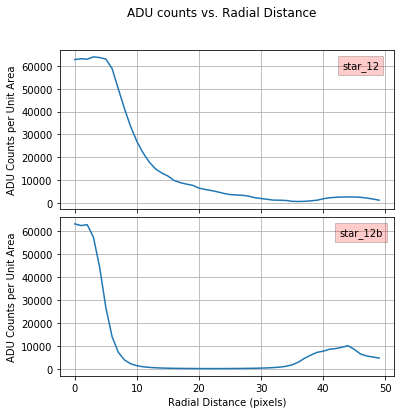

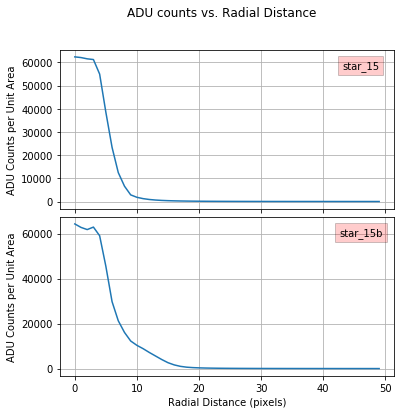

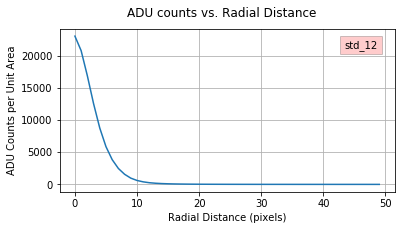

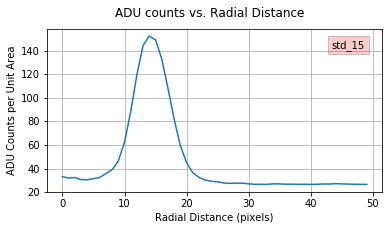

In [7]:
# Plot photon counts as a function of radius given the position of the source. Useful for determining aperture parameters

def plot_radial_counts(data, source_centroids, name, name2 = "YEET"):
    names = [name, name2]
    n_sources = len(source_centroids)
    fig, axes = plt.subplots(n_sources, 1, 
                             sharex=True, figsize=(6, 3*n_sources))

    # Loop over sources
    if n_sources > 1:
        for i in range(n_sources):
            radius = 0
            radii = []
            photon_counts = []

            # Most sources are much smaller than 25 pixels in radius
            # But can definitely increase this value if needed!
            # This also gives a good sense of background counts
            while radius < 50:
                # Create the aperture
                aperture = CircularAnnulus(source_centroids[i],
                                           r_in = radius, r_out = radius+1)
                # Do the photometry
                phot_table = aperture_photometry(data, aperture, method='subpixel')

                # Determine number of photon counts per unit area
                photon_counts.append(phot_table['aperture_sum']/aperture.area())

                radii.append(radius)
                radius += 1

            # Plot the data
            # plt.clf()
            axes[i].grid(True)
            axes[i].plot(radii, photon_counts)
            axes[i].set_ylabel("ADU Counts per Unit Area")
            axes[i].text(0.9,0.9, names[i], horizontalalignment='center',
                         verticalalignment='center',transform=axes[i].transAxes, 
                         bbox=dict(facecolor='red', alpha=0.2))

        fig.subplots_adjust(hspace=0.05)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
        plt.suptitle("ADU counts vs. Radial Distance")
        plt.xlabel("Radial Distance (pixels)")
        # plt.ylabel("ADU Counts per Unit Area")
    if n_sources == 1:
        radius = 0
        radii = []
        photon_counts = []

        # Most sources are much smaller than 25 pixels in radius
        # But can definitely increase this value if needed!
        # This also gives a good sense of background counts
        while radius < 50:
            # Create the aperture
            aperture = CircularAnnulus(source_centroids,
                                       r_in = radius, r_out = radius+1)
            # Do the photometry
            phot_table = aperture_photometry(data, aperture, method='subpixel')

            # Determine number of photon counts per unit area
            photon_counts.append(phot_table['aperture_sum']/aperture.area())

            radii.append(radius)
            radius += 1

        # Plot the data
        # plt.clf()
        axes.grid(True)
        axes.plot(radii, photon_counts)
        axes.set_ylabel("ADU Counts per Unit Area")
        axes.text(0.9,0.9, names[0], horizontalalignment='center',
                     verticalalignment='center',transform=axes.transAxes, 
                     bbox=dict(facecolor='red', alpha=0.2))

    fig.subplots_adjust(hspace=0.05)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.suptitle("ADU counts vs. Radial Distance")
    plt.xlabel("Radial Distance (pixels)")
    # plt.ylabel("ADU Counts per Unit Area")
        
plot_radial_counts(data[0], pix_coords_12, "star_12", "star_12b")
plot_radial_counts(data[1], pix_coords_15, "star_15", "star_15b")
plot_radial_counts(std_data[0], pix_coords_std_12, "std_12")
plot_radial_counts(std_data[1], pix_coords_std_15, "std_15")

In [8]:
# Define your aperture sizes (in pixels)
# Add additional apertures if you have more than two objects

star_12_ap, star_12_bkg_in, star_12_bkg_out = 30, 35, 40
star_12b_ap, star_12b_bkg_in, star_12b_bkg_out = 20, 25, 30

star_15_ap, star_15_bkg_in, star_15_bkg_out = 15, 20, 25
star_15b_ap, star_15b_bkg_in, star_15b_bkg_out = 20, 25, 30

std_12_ap, std_12_bkg_in, std_12_bkg_out = 12, 17, 22
std_15_ap, std_15_bkg_in, std_15_bkg_out = 23, 28, 33


In [9]:
def do_ap_photometry(data, source_centroid, r_ap, bg_rin, bg_rout, airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        Flux and flux error due to source, background subtracted
    """
    
    # Change to appropriate MDM values
    # Values are likely in FITS header...
    read_noise = 10
    gain = 4
    
    # Create the source and background apertures
    aperture = CircularAperture(source_centroid, r=r_ap)
    bg_aperture = CircularAnnulus(source_centroid,
                                  r_in = bg_rin,
                                  r_out = bg_rout)

    # Do the aperture photometry                              
    rawflux_table = aperture_photometry(data, aperture)
    bkgflux_table = aperture_photometry(data, bg_aperture)

    # Correct for aatmospheric extinction
    rawflux_table['aperture_sum_corr'] = flux_airmass_correction(rawflux_table['aperture_sum'], airmass, filt)
    bkgflux_table['aperture_sum_corr'] = flux_airmass_correction(bkgflux_table['aperture_sum'], airmass, filt)
    
    phot_table = hstack([rawflux_table, bkgflux_table], 
                         table_names=['raw', 'bkg'])

    # Get the mean number of background counts per unit area                    
    bkg_mean = phot_table['aperture_sum_corr_bkg'] / bg_aperture.area()

    # Calculate number of background counts in source aperture
    bkg_sum = bkg_mean*aperture.area()

    # Calculate the true number of source photon counts in
    # source aperture
    final_flux = phot_table["aperture_sum_corr_raw"]-bkg_sum
    final_flux_err = np.sqrt(final_flux + bkg_sum + aperture.area()*read_noise**2*gain)
    
    print ("Background sum = ", bkg_sum.data, "\n")
    print ("Object Counts = ", final_flux.data, "\n")
    
    return final_flux, final_flux_err


def calculate_zeropoint(data, source_centroid, r_ap,
                        bg_rin, bg_rout, known_mag, airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        The zero point magnitude and error
    """

    final_flux, final_flux_err = do_ap_photometry(data, source_centroid, r_ap, 
                                                  bg_rin, bg_rout, airmass, filt)

    # Calculate the zero point using the known magnitude
    zp =  known_mag+2.5*np.log10(final_flux)
    zp_err = np.sqrt( ((-2.5/final_flux)*final_flux_err)**2)
    
    return zp.data, zp_err.data


def calculate_magnitude(data, source_centroid, r_ap, 
                        bg_rin, bg_rout, zeropoint, zeropoint_err,
                        airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        The object magnitude and error
    """
    
    final_flux, final_flux_err = do_ap_photometry(data, source_centroid, r_ap, 
                                                  bg_rin, bg_rout, airmass, filt)
    
    # Calculate source magnitude using source photon counts
    # and previously determined zero point
    mag = -2.5*np.log10(final_flux) + zeropoint

    mag_err = np.sqrt( ((-2.5/final_flux)*final_flux_err)**2 + zeropoint_err**2)

    return mag.data, mag_err.data

In [10]:
print("-"*70)
print("| Zero point")
print("-"*70)
zeropoint, zeropoint_err = calculate_zeropoint(std_data[0], (x_pix_std_12[0], y_pix_std_12[0]), 
                                               std_12_ap, std_12_bkg_in, 
                                               std_12_bkg_out, obj_coords_table.Rmag[4],
                                               std_airmass[0], std_filt[0])
print("Zeropoint, error = ",zeropoint, zeropoint_err)


print("\n" + "-"*70)
print("| Star 12 R Mag")
print("-"*70)
star_12_mag, star_12_err = calculate_magnitude(data[0], (x_pix_12[0], y_pix_12[0]), 
                                       star_12_ap, star_12_bkg_in, star_12_bkg_out, 
                                       zeropoint, zeropoint_err,
                                       airmass[0], filt[0])
print("Star 12 Magnitude, error = ", star_12_mag, star_12_err)

----------------------------------------------------------------------
| Zero point
----------------------------------------------------------------------
Background sum =  [25145.24474284] 

Object Counts =  [1848291.15790556] 

Zeropoint, error =  [25.99692596] [0.0019387]

----------------------------------------------------------------------
| Star 12 R Mag
----------------------------------------------------------------------
Background sum =  [2488868.73867697] 

Object Counts =  [34716004.83141033] 

Star 12 Magnitude, error =  [7.14560161] [0.00198931]


In [11]:
print("-"*70)
print("| Zero point")
print("-"*70)
zeropoint, zeropoint_err = calculate_zeropoint(std_data[0], (x_pix_std_12[0], y_pix_std_12[0]), 
                                               std_12_ap, std_12_bkg_in, 
                                               std_12_bkg_out, obj_coords_table.Rmag[4],
                                               std_airmass[0], std_filt[0])
print("Zeropoint, error = ",zeropoint, zeropoint_err)


print("\n" + "-"*70)
print("| Star 12b Mag")
print("-"*70)
star_12b_mag, star_12b_err = calculate_magnitude(data[0], (x_pix_12[1], y_pix_12[1]), 
                                       star_12b_ap, star_12b_bkg_in, star_12b_bkg_out, 
                                       zeropoint, zeropoint_err,
                                       airmass[0], filt[0])
print("Star 12b Magnitude, error = ", star_12b_mag, star_12b_err)

----------------------------------------------------------------------
| Zero point
----------------------------------------------------------------------
Background sum =  [25145.24474284] 

Object Counts =  [1848291.15790556] 

Zeropoint, error =  [25.99692596] [0.0019387]

----------------------------------------------------------------------
| Star 12b Mag
----------------------------------------------------------------------
Background sum =  [475073.91409846] 

Object Counts =  [7053680.74931516] 

Star 12b Magnitude, error =  [8.87588647] [0.00218345]


In [12]:
print("-"*70)
print("| Zero point")
print("-"*70)
zeropoint, zeropoint_err = calculate_zeropoint(std_data[1], (x_pix_std_15[0], y_pix_std_15[0]), 
                                               std_15_ap, std_15_bkg_in, 
                                               std_15_bkg_out, obj_coords_table.Rmag[5],
                                               std_airmass[1], std_filt[1])
print("Zeropoint, error = ",zeropoint, zeropoint_err)


print("\n" + "-"*70)
print("| Star 15 Mag")
print("-"*70)
star_15_mag, star_15_err = calculate_magnitude(data[1], (x_pix_15[0], y_pix_15[0]), 
                                       star_15_ap, star_15_bkg_in, star_15_bkg_out, 
                                       zeropoint, zeropoint_err,
                                       airmass[1], filt[1])
print("Star 15 Magnitude, error = ", star_15_mag, star_15_err)

----------------------------------------------------------------------
| Zero point
----------------------------------------------------------------------
Background sum =  [47033.03998896] 

Object Counts =  [88267.31303388] 

Zeropoint, error =  [26.84549977] [0.02533388]

----------------------------------------------------------------------
| Star 15 Mag
----------------------------------------------------------------------
Background sum =  [79461.61698543] 

Object Counts =  [8718273.23706032] 

Star 15 Magnitude, error =  [9.49442358] [0.02534861]


In [13]:
print("-"*70)
print("| Zero point")
print("-"*70)
zeropoint, zeropoint_err = calculate_zeropoint(std_data[1], (x_pix_std_15[0], y_pix_std_15[0]), 
                                               std_15_ap, std_15_bkg_in, 
                                               std_15_bkg_out, obj_coords_table.Rmag[5],
                                               std_airmass[1], std_filt[1])
print("Zeropoint, error = ",zeropoint, zeropoint_err)


print("\n" + "-"*70)
print("| Star 15b Mag")
print("-"*70)
star_15b_mag, star_15b_err = calculate_magnitude(data[1], (x_pix_15[1], y_pix_15[1]), 
                                       star_15b_ap, star_15b_bkg_in, star_15b_bkg_out, 
                                       zeropoint, zeropoint_err,
                                       airmass[1], filt[1])
print("Star 15b Magnitude, error = ", star_15b_mag, star_15b_err)

----------------------------------------------------------------------
| Zero point
----------------------------------------------------------------------
Background sum =  [47033.03998896] 

Object Counts =  [88267.31303388] 

Zeropoint, error =  [26.84549977] [0.02533388]

----------------------------------------------------------------------
| Star 15b Mag
----------------------------------------------------------------------
Background sum =  [112426.60984536] 

Object Counts =  [14065949.66388875] 

Star 15b Magnitude, error =  [8.97507712] [0.02534303]


In [14]:
def distance_modulus(m, M):
    return 10**((m - M + 5)/5) # distance in parsecs

# http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1990PASP..102..379W&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
sptype_12 = "B9"
spytype_12b = "B1"
sptype_15 = "A1"
sptype_15b = "B9"

# https://academic.oup.com/mnras/article/371/1/185/979717
# M_12 = -2.95
# M_12b = 0.21 
# M_15 = 0.29 
# M_15b = 1 # https://www.cambridge.org/core/services/aop-cambridge-core/content/view/4A9DAAE0095FC24FEB153013AA513361/S1743921304004314a.pdf/physical_properties_of_normal_a_stars.pdf

M_12 = 1.58 # worked backwards from gaia distance
M_12b = 2.91 
M_15 = 3.94 # worked backwards from gaia distance
M_15b = 3.33 
d_12 = distance_modulus(star_12_mag, M_12)
d_12b = distance_modulus(star_12b_mag, M_12b)
d_15 = distance_modulus(star_15_mag, M_15)
d_15b = distance_modulus(star_15b_mag, M_15b)

print(d_12, d_12b)
print(d_15, d_15b)

# http://vizier.u-strasbg.fr/viz-bin/VizieR-4
#  	ROSAT all-sky survey catalogue of OB stars (Berghoefer+ 1996)

[129.7538709] [156.0189293]
[129.08765609] [134.59081523]


In [15]:
# Mass Ratio
mass_12 = 13.21 # https://iopscience.iop.org/article/10.1088/0004-637X/795/1/82/meta
mass_12b =  3.29# https://www.cambridge.org/core/journals/proceedings-of-the-international-astronomical-union/article/physical-properties-of-normal-a-stars/4A9DAAE0095FC24FEB153013AA513361
q_12 = 3.29 / 13.21
print(q_12)

mass_15 = 3.29 # https://iopscience.iop.org/article/10.1088/0004-637X/795/1/82/meta
mass_15b = 2.3 # https://www.cambridge.org/core/journals/proceedings-of-the-international-astronomical-union/article/physical-properties-of-normal-a-stars/4A9DAAE0095FC24FEB153013AA513361
q_15 = 2.3 / 3.29
print(q_15)

0.24905374716124146
0.6990881458966565


In [16]:
pixel_dist_12 = np.sqrt((x_pix_12[0] - x_pix_12[1])**2 + (y_pix_12[0] - y_pix_12[1])**2)
width = 4064
pixel_ratio = pixel_dist_12 / width
fov = 1278 # arcsec
angular_sep_12 = pixel_ratio * fov
sep_12 = angular_sep_12 * d_12

pixel_dist_15 = np.sqrt((x_pix_15[0] - x_pix_15[1])**2 + (y_pix_15[0] - y_pix_15[1])**2)
width = 4064
pixel_ratio = pixel_dist_15 / width
fov = 1278 # arcsec
angular_sep_15 = pixel_ratio * fov
sep_15 = angular_sep_15 * d_15

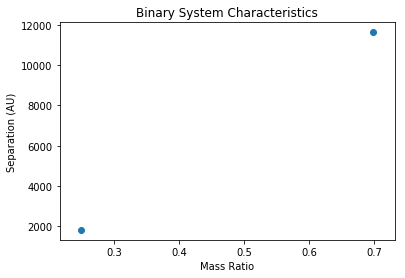

In [17]:
q = [q_12, q_15]
a = [sep_12, sep_15]
plt.scatter(q, a)
# plt.yscale("log")
plt.title("Binary System Characteristics")
plt.xlabel("Mass Ratio")
plt.ylabel("Separation (AU)")
plt.show()

In [18]:
print(q)
print(a)

[0.24905374716124146, 0.6990881458966565]
[array([1827.9593571]), array([11627.97733577])]
